Implementation of projection classification model using MLPs.

In [4]:
### REQUIRED PACKAGES

import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_X_y
from itertools import combinations
import torch.nn.functional as F
from collections import defaultdict
import torch.nn as nn
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

Class producing pairwise scores for each embedding. Commented and optimized using ChatGPT.

In [5]:
class PairwiseCPS:
    """
    Class for pairwise contrastive projection signatures (CPS)
    between two classes (cls_a and cls_b). It projects input samples
    into a 2D space using directional and signature projections.

    Attributes:
        few_shot_n (int): Number of few-shot examples to use for centroid computation.
    """

    def __init__(self, cls_a, cls_b, few_shot_n=8):
        self.cls_a = cls_a
        self.cls_b = cls_b
        self.few_shot_n = few_shot_n
        self.diff_vector = None   # Vector from class B to A centroids
        self.signature = None     # Mean normalized vector for class A
        self.mean = None          # Feature-wise mean
        self.std = None           # Feature-wise std (used for normalization)

    def fit(self, X, y):
        """
        Fit the CPS representation using few-shot examples.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Class labels.
        """
        mask = np.isin(y, [self.cls_a, self.cls_b])
        X = X[mask]
        y = y[mask]

        # Normalize input
        self.mean = X.mean(0)
        self.std = X.std(0)
        self.std[self.std == 0] = 1.0
        X_norm = (X - self.mean) / self.std

        # Few-shot class centroids (perhaps randomize few-shot selection?)
        #pos = X[y == self.cls_a][:self.few_shot_n]
        #neg = X[y == self.cls_b][:self.few_shot_n]
        pos_indices = np.where(y == self.cls_a)[0]
        neg_indices = np.where(y == self.cls_b)[0]

        # Randomly choose few-shot samples (without replacement if possible)
        pos_few = np.random.choice(pos_indices, size=min(self.few_shot_n, len(pos_indices)), replace=False)
        neg_few = np.random.choice(neg_indices, size=min(self.few_shot_n, len(neg_indices)), replace=False)

        pos = X[pos_few]
        neg = X[neg_few]
        
        centroid_pos = pos.mean(0)
        centroid_neg = neg.mean(0)

        # Unit vector between class centroids
        self.diff_vector = centroid_pos - centroid_neg
        self.diff_vector /= np.linalg.norm(self.diff_vector)

        # Signature vector (class A mean direction in normalized space)
        self.signature = X_norm[y == self.cls_a].mean(0)
        self.signature /= np.linalg.norm(self.signature)

    def score(self, X):
        """
        Project input X into 2D space using the learned diff_vector and signature.

        Returns:
            np.ndarray: A (n_samples, 2) array with pairwise projection scores.
        """
        X_norm = (X - self.mean) / self.std

        # Project onto diff_vector (centroid difference)
        dim_score = (X @ self.diff_vector)
        dim_score /= np.linalg.norm(dim_score)

        # Project onto class A signature
        sim_score = (X_norm @ self.signature)
        sim_score /= np.linalg.norm(sim_score)

        return np.vstack([dim_score, sim_score]).T

Implementation of customizable MLP class. Commented and optimized using ChatGPT.

In [6]:
class DeeperMLP(nn.Module):
    """
    A configurable multi-layer perceptron (MLP) with BatchNorm and Dropout.
    """

    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.3):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Final implementation leveraging and combining earlier classes. Optimized and commented using ChatGPT.

In [7]:
class CPS_MLP_Classifier(BaseEstimator, ClassifierMixin):
    """
    One-vs-One CPS-based classification ensemble using MLPs.
    """

    def __init__(
        self,
        few_shot_n=8,
        hidden_dims=[32, 16, 8],
        epochs=100,
        batch_size=64,
        lr=5e-4,
        dropout=0.3,
        n_estimators=4,
    ):
        self.few_shot_n = few_shot_n
        self.hidden_dims = hidden_dims
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.dropout = dropout
        self.n_estimators = n_estimators
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.classifiers = {}   # Dict of (class_a, class_b) -> PairwiseCPS
        self.pairs = []         # All class pairs
        self.models = []        # List of trained MLP classifiers
        self.le = LabelEncoder()
        self.classes_ = None

    def fit(self, X, y):
        """
        Fit the OvO CPS ensemble on training data.

        Args:
            X (np.ndarray): Input features.
            y (np.ndarray): Target labels.
        """
        X, y = check_X_y(X, y)
        y = self.le.fit_transform(y)
        self.classes_ = np.unique(y)
        self.pairs = list(combinations(self.classes_, 2))

        all_features = []

        # Train all pairwise CPS classifiers
        for (a, b) in self.pairs:
            clf = PairwiseCPS(a, b, self.few_shot_n)
            clf.fit(X, y)
            self.classifiers[(a, b)] = clf
            all_features.append(clf.score(X))  # (n_samples, 2)

        # Stack all CPS scores for final feature representation
        X_feat = np.hstack(all_features)
        X_tensor = torch.FloatTensor(X_feat)
        y_tensor = torch.LongTensor(y)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        input_dim = X_feat.shape[1]
        num_classes = len(self.classes_)

        # Train MLP ensemble
        self.models = []
        for i in range(self.n_estimators):
            model = DeeperMLP(input_dim, self.hidden_dims, num_classes, dropout=self.dropout).to(self.device)
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
            loss_fn = nn.CrossEntropyLoss()

            model.train()
            for epoch in range(self.epochs):
                for xb, yb in loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    logits = model(xb)
                    loss = loss_fn(logits, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            self.models.append(model)

        return self

    def _compute_features(self, X):
        """
        Project input X using all pairwise CPS classifiers.

        Returns:
            np.ndarray: Feature representation for ensemble MLPs.
        """
        all_scores = []
        for (a, b), clf in self.classifiers.items():
            scores = clf.score(X)
            all_scores.append(scores)
        return np.hstack(all_scores)

    def predict_proba(self, X):
        """
        Predict class probabilities by averaging ensemble outputs.

        Returns:
            np.ndarray: Class probability distribution (n_samples, n_classes)
        """
        X_feat = self._compute_features(X)
        X_tensor = torch.FloatTensor(X_feat).to(self.device)
        ensemble_probs = []

        for model in self.models:
            model.eval()
            with torch.no_grad():
                logits = model(X_tensor)
                probs = F.softmax(logits, dim=1).cpu().numpy()
                ensemble_probs.append(probs)

        avg_probs = np.mean(ensemble_probs, axis=0)
        return avg_probs

    def predict(self, X):
        """
        Predict class labels.

        Returns:
            np.ndarray: Predicted class labels (original encoding)
        """
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        return self.le.inverse_transform(preds)

    def score(self, X, y):
        """
        Compute accuracy.

        Returns:
            float: Accuracy score.
        """
        preds = self.predict(X)
        return np.mean(preds == y)

    def plot_predictions(model, X, y_true, indices, figsize=(6, 3)):
        """
        Plot prediction heatmaps vertically with title color indicating correctness.

        Args:
            model (OvO_CPS_Ensemble): Trained model.
            X (np.ndarray): Input data.
            y_true (list or np.ndarray): True labels (original form).
            indices (list): Indices of samples to plot.
            figsize (tuple): Size of the matplotlib figure.
        """
        y_pred = model.predict(X)
        probs = model.predict_proba(X)

        n_samples = len(indices)
        n_classes = probs.shape[1]
        class_labels = model.le.inverse_transform(np.arange(n_classes))

        fig, axes = plt.subplots(n_samples, 1, figsize=figsize, sharex=True)

        if n_samples == 1:
            axes = [axes]

        for ax, idx in zip(axes, indices):
            sample_probs = probs[idx]

            sns.heatmap(
                sample_probs[np.newaxis, :],
                annot=True,
                fmt=".2f",
                cmap="YlGnBu",
                cbar=False,
                xticklabels=class_labels,
                yticklabels=["Prob"],
                ax=ax,
            )
            ax.tick_params(axis='x', rotation=45)

            correct = (y_pred[idx] == y_true[idx])
            color = "green" if correct else "red"
            ax.set_title(f"Idx {idx} — True: {y_true[idx]} | Pred: {y_pred[idx]}", color=color)

        plt.tight_layout()
        plt.show()

Example multi-class implementation and evaluation of model on OpenAI embeddings

In [16]:
### EXAMPLE USE CASE

### Avg binary accuracy: 88%; multi-class accuracy: 79-81% (dependent on hyperparameters)

seed = 2025

# Read data
chatgpt_data = pd.read_csv("embeddingsChatGPT.csv")

# Convert string embeddings to lists of floats
embeddings = chatgpt_data['embedding'].apply(ast.literal_eval).to_list()

# Convert list of lists to numpy array
X = np.array(embeddings)

# Apply mask on X and y to filter out undesired labels
mask = chatgpt_data['section_label'].isin([0, 1, 2, 3, 4, 5])
X = X[mask]
y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=seed
)


In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss
import numpy as np

model = CPS_MLP_Classifier(
                few_shot_n=16,
                n_estimators=1,
                hidden_dims=[32, 16, 8],
                epochs=200,
                batch_size=64,
                lr=5e-4,
                dropout=0.3
            )

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

# Per-class breakdown
precision_c, recall_c, f1_c, support_c = precision_recall_fscore_support(
    y_test, y_pred, average=None, zero_division=0, labels=model.le.transform(model.le.classes_)
)

# Confidence & Entropy
avg_confidence = np.mean(np.max(probs, axis=1))
entropy = -np.mean(np.sum(probs * np.log(probs + 1e-12), axis=1))

# Log Loss
try:
    ll = log_loss(model.le.transform(y_test), probs, labels=list(range(len(model.le.classes_))))
except ValueError:
    ll = np.nan

# Print summary
print(f"Accuracy: {acc:.3f}")
print(f"Precision (weighted): {precision:.3f}")
print(f"Recall (weighted): {recall:.3f}")
print(f"F1 Score (weighted): {f1:.3f}")
print(f"Log Loss: {ll:.3f}")
print(f"Avg Confidence: {avg_confidence:.3f}")
print(f"Avg Entropy: {entropy:.3f}")

# Per-class metrics
for i, label in enumerate(model.le.classes_):
    print(f"{label}: Precision={precision_c[i]:.3f}, Recall={recall_c[i]:.3f}, "
          f"F1={f1_c[i]:.3f}, Support={support_c[i]}")


Accuracy: 0.805
Precision (weighted): 0.804
Recall (weighted): 0.805
F1 Score (weighted): 0.803
Log Loss: 0.529
Avg Confidence: 0.786
Avg Entropy: 0.552
0: Precision=0.700, Recall=0.755, F1=0.726, Support=102
1: Precision=0.951, Recall=0.951, F1=0.951, Support=102
2: Precision=0.935, Recall=0.971, F1=0.952, Support=103
3: Precision=0.730, Recall=0.794, F1=0.761, Support=102
4: Precision=0.757, Recall=0.757, F1=0.757, Support=103
5: Precision=0.753, Recall=0.598, F1=0.667, Support=102


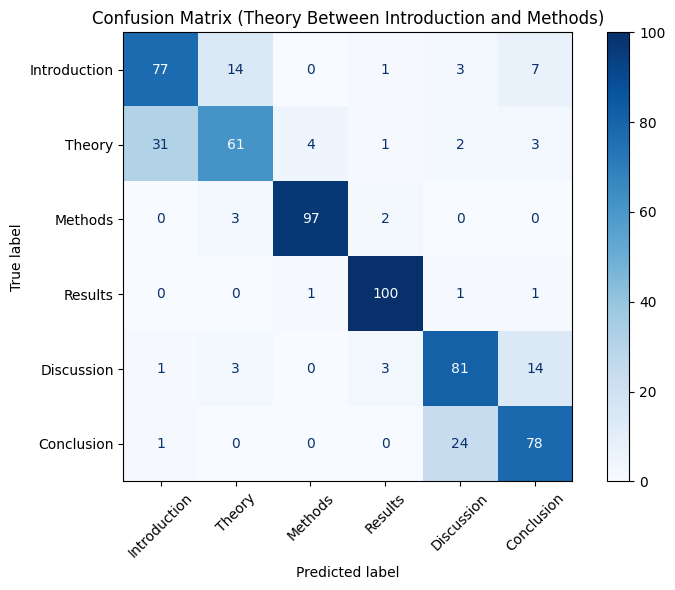

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define textual class labels (id-to-label mapping)
id2label = {
    0: 'Introduction',
    1: 'Methods',
    2: 'Results',
    3: 'Discussion',
    4: 'Conclusion',
    5: 'Theory'
}

# Define new custom label order (putting Theory between Introduction and Methods)
custom_order = [0, 5, 1, 2, 3, 4]
ordered_labels = [id2label[i] for i in custom_order]

# Get encoded string labels for test data if needed
# Assumes y_test and y_pred are in encoded integer format
y_test_named = [id2label[i] for i in y_test]
y_pred_named = [id2label[i] for i in y_pred]

# Compute confusion matrix with textual label order
cm = confusion_matrix(y_test_named, y_pred_named, labels=ordered_labels)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix (Theory Between Introduction and Methods)")
plt.tight_layout()
plt.show()


Testing performance for different parameters.

In [ ]:
for n_estimators in [1, 2, 4, 8]:
    for hidden_dim in [32, 64, 128]:
        for epochs in [50, 100, 200]:
            hidden_dims = [hidden_dim, hidden_dim // 2, hidden_dim // 4]  # Example: [128, 64, 32, 16]

            clf = CPS_MLP_Classifier(
                n_estimators=n_estimators,
                hidden_dims=hidden_dims,
                epochs=epochs,
                batch_size=64,
                lr=5e-4,
                dropout=0.3
            )
            clf.fit(X_train, y_train)
            acc = clf.score(X_test, y_test)
            print(
                f"Test accuracy: {acc:.4f} "
                f"(n_estimators={n_estimators}, hidden_dims={hidden_dims}, epochs={epochs})"
            )

Test accuracy: 0.7834 (n_estimators=1, hidden_dims=[32, 16, 8], epochs=50)
Test accuracy: 0.7801 (n_estimators=1, hidden_dims=[32, 16, 8], epochs=100)
Test accuracy: 0.8078 (n_estimators=1, hidden_dims=[32, 16, 8], epochs=200)
Test accuracy: 0.7769 (n_estimators=1, hidden_dims=[64, 32, 16], epochs=50)
Test accuracy: 0.7671 (n_estimators=1, hidden_dims=[64, 32, 16], epochs=100)
Test accuracy: 0.8013 (n_estimators=1, hidden_dims=[64, 32, 16], epochs=200)
Test accuracy: 0.7752 (n_estimators=1, hidden_dims=[128, 64, 32], epochs=50)
Test accuracy: 0.7671 (n_estimators=1, hidden_dims=[128, 64, 32], epochs=100)
Test accuracy: 0.7199 (n_estimators=1, hidden_dims=[128, 64, 32], epochs=200)
Test accuracy: 0.7801 (n_estimators=2, hidden_dims=[32, 16, 8], epochs=50)
Test accuracy: 0.7997 (n_estimators=2, hidden_dims=[32, 16, 8], epochs=100)
Test accuracy: 0.7492 (n_estimators=2, hidden_dims=[32, 16, 8], epochs=200)
Test accuracy: 0.7801 (n_estimators=2, hidden_dims=[64, 32, 16], epochs=50)
Test ac

Testing binary performance on OpenAI embeddings.

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import numpy as np
from itertools import combinations

all_labels = [0, 1, 2, 3, 4, 5]
metrics_list = []

for label1, label2 in combinations(all_labels, 2):
    # Convert list of lists to numpy array
    X = np.array(embeddings)
    # Apply mask on X and y to filter out undesired labels
    mask = chatgpt_data['section_label'].isin([label1,label2])
    X = X[mask]
    y = chatgpt_data.loc[mask, 'section_label'].to_numpy()

# Split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=seed
    )

    # Binarize: label2 is the positive class
    y_train_bin = (y_train == label2).astype(int)
    y_test_bin = (y_test == label2).astype(int)

    # Train and evaluate
    model = CPS_MLP_Classifier(
        few_shot_n=8,
        hidden_dims= [32, 16, 8],
        epochs = 200
    )
    model.fit(X_train, y_train_bin)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    acc = accuracy_score(y_test_bin, preds)
    prec = precision_score(y_test_bin, preds, zero_division=0)
    rec = recall_score(y_test_bin, preds, zero_division=0)
    f1 = f1_score(y_test_bin, preds, zero_division=0)

    metrics_list.append({
        "pair": f"{label1} vs {label2}",
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    })

# Convert to array for summary statistics
metrics_array = {key: np.array([m[key] for m in metrics_list]) for key in ["accuracy", "precision", "recall", "f1"]}

# Summary
summary = {
    "avg": {k: np.mean(v) for k, v in metrics_array.items()},
    "max": {k: np.max(v) for k, v in metrics_array.items()},
    "min": {k: np.min(v) for k, v in metrics_array.items()}
}

# Print results
print("=== Binary Class Pair Evaluation ===")
for m in metrics_list:
    print(f"{m['pair']}: Acc={m['accuracy']:.3f}, Prec={m['precision']:.3f}, Rec={m['recall']:.3f}, F1={m['f1']:.3f}")

print("\n=== Summary ===")
for stat, values in summary.items():
    print(f"\n{stat.upper()}:")
    for metric, value in values.items():
        print(f"{metric}: {value:.3f}")


=== Binary Class Pair Evaluation ===
0 vs 1: Acc=0.961, Prec=0.950, Rec=0.983, F1=0.966
0 vs 2: Acc=0.961, Prec=0.927, Rec=1.000, F1=0.962
0 vs 3: Acc=0.863, Prec=0.925, Rec=0.771, F1=0.841
0 vs 4: Acc=0.888, Prec=0.958, Rec=0.829, F1=0.889
0 vs 5: Acc=0.751, Prec=0.737, Rec=0.800, F1=0.767
1 vs 2: Acc=0.873, Prec=0.875, Rec=0.875, F1=0.875
1 vs 3: Acc=0.985, Prec=0.991, Rec=0.981, F1=0.986
1 vs 4: Acc=0.946, Prec=0.931, Rec=0.959, F1=0.945
1 vs 5: Acc=0.922, Prec=0.915, Rec=0.915, F1=0.915
2 vs 3: Acc=0.873, Prec=0.895, Rec=0.842, F1=0.867
2 vs 4: Acc=0.971, Prec=0.979, Rec=0.959, F1=0.969
2 vs 5: Acc=0.946, Prec=0.946, Rec=0.955, F1=0.950
3 vs 4: Acc=0.795, Prec=0.758, Rec=0.875, F1=0.812
3 vs 5: Acc=0.883, Prec=0.873, Rec=0.906, F1=0.889
4 vs 5: Acc=0.917, Prec=0.892, Rec=0.922, F1=0.907

=== Summary ===

AVG:
accuracy: 0.902
precision: 0.903
recall: 0.905
f1: 0.903

MAX:
accuracy: 0.985
precision: 0.991
recall: 1.000
f1: 0.986

MIN:
accuracy: 0.751
precision: 0.737
recall: 0.771
f1

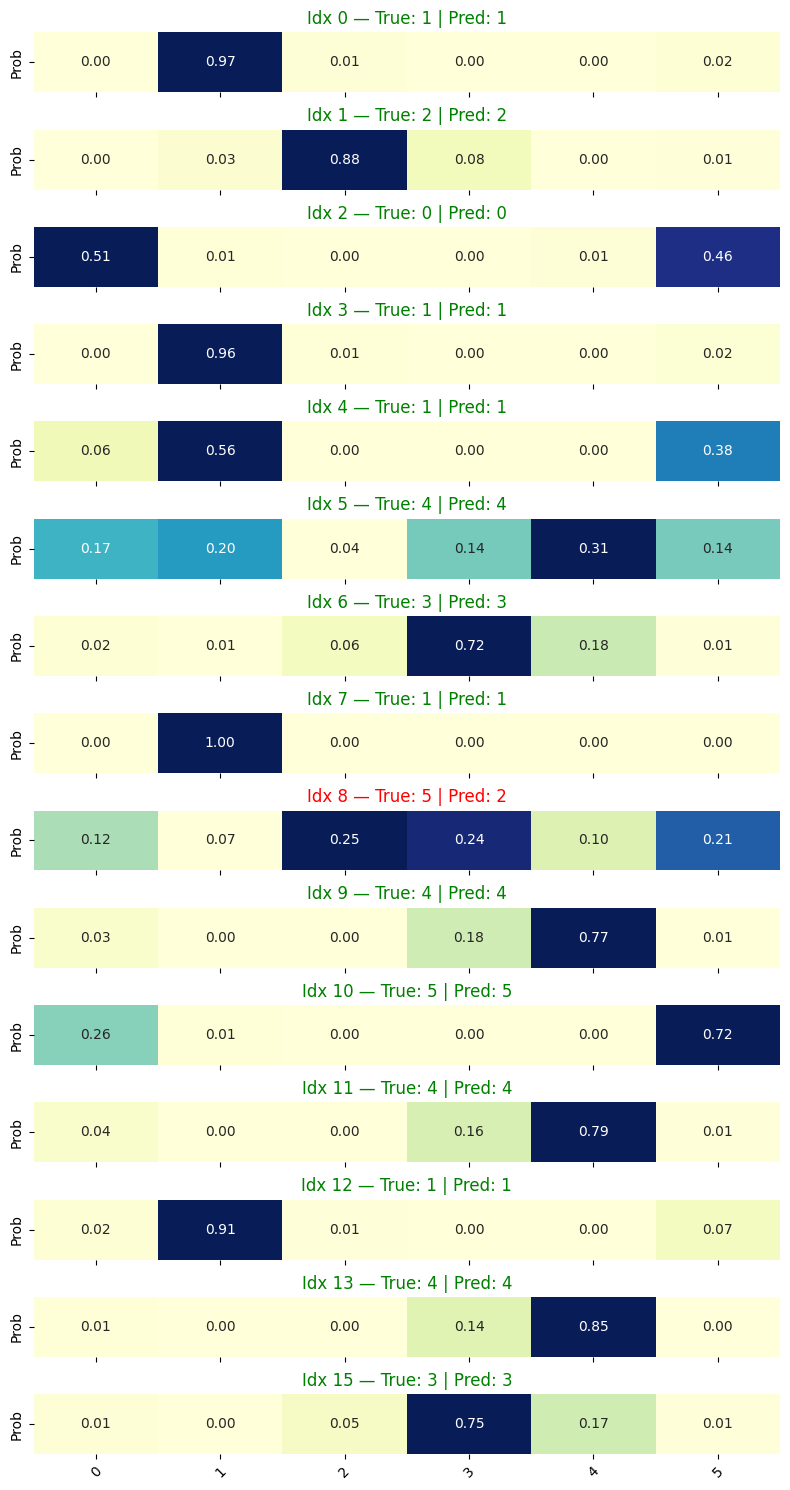

In [25]:
# Optional plotting of model predictions per sample
n_plot = 15
indices = np.linspace(0, n_plot, n_plot).astype(int).tolist()
model.plot_predictions(X_test, y_test, indices, figsize=(8, len(indices)))

Applying model to classified Theoretical Frameworks.

Attempting to classify theoretical frameworks in highest/lowest average citation/year quantiles.

In [27]:
import ast
theory_cite = pd.read_csv('theory_classifications_w_citations')
theory_cite['citation_idx'] = pd.qcut(theory_cite['citationsPerYear'], q=8)
X_theory = np.array(theory_cite['section_content_embedding'].apply(ast.literal_eval).to_list())
y_theory = theory_cite['citation_idx']
y_numeric, label_names = pd.factorize(y_theory)

mask = np.isin(y_numeric, [0, 3])
X = X_theory[mask]
y = y_numeric[mask]

In [28]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=2025)

In [29]:
clf = CPS_MLP_Classifier(
)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)

In [30]:
acc

np.float64(0.7619047619047619)